# E-Commerce Customer Behavior Analysis

# Importing Libraries and Data Loading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("C:/Users/tohid/OneDrive/Desktop/Data Analysis/Project/E-Commerce Project/data/raw/E-Commerce_data.csv")

## 2. Initial Data Exploration

In [2]:
print(f"Dataset shape: {df.shape}")
df.info()
df.head()

Dataset shape: (3349140, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3349140 entries, 0 to 3349139
Data columns (total 19 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   id                                object 
 1   gender                            object 
 2   age                               int64  
 3   marital_status                    object 
 4   education_level                   object 
 5   occupation                        object 
 6   income                            int64  
 7   state                             object 
 8   city                              object 
 9   returning                         object 
 10  product                           object 
 11  category                          object 
 12  purchase_amount                   float64
 13  purchase_date                     object 
 14  returned                          object 
 15  return_date                       object 
 16  Preferr

,id,gender,age,marital_status,education_level,occupation,income,state,city,returning,product,category,purchase_amount,purchase_date,returned,return_date,Preferred_Shopping_Channels,Preferred_Payment_Methods,Preferred_Communication_Channels
0,CUS2345963879,Male,20,Married,High School,Pest Control Technician,0,Washington,Olympia,yes,Violin,Musical Instruments,1500.00,2022-07-24 19:12:57,no,NaN,In-store,PayPal,Email
1,CUS1154018970,Female,51,Single,Master's,Conflict Resolution Specialist,10721,New York,New York City,yes,Portable Charger,Electronics,20.00,2022-04-14 04:17:11,exchange,2022-04-17 18:58:51,In-store,cash,Email
2,CUS1607529340,Male,19,Married,High School,Auctioneer,6222,Nevada,Henderson,yes,Staples,Office Supplies & Stationery,6.25,2023-03-10 06:32:39,no,NaN,Mobile App,Debit Card,Email
3,CUS8672735648,Female,33,Married,PhD,Psychiatrist,45127,Nevada,Las Vegas,yes,Bread Maker,Home & Kitchen Appliances,150.00,2023-08-19 06:30:32,exchange,2023-09-03 05:58:42,Website,cash,Email
4,CUS3043051648,Female,45,Widowed,Master's,Conflict Resolution Specialist,13739,Nevada,Henderson,no,Leather Conditioner,Automotive Parts & Accessories,18.75,2022-05-05 05:23:56,no,NaN,Mobile App,cash,Email


Key Observations:

- 3.3M records with 19 features
- Mixed data types (numeric/categorical)
- Missing values in return_date (67% missing)

## 3. Data Cleaning

In [3]:
# Convert date columns
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df['return_date'] = pd.to_datetime(df['return_date'], errors='coerce')

# Handle zero income values
mask = df["income"] < 1000
occupations = df[mask]["occupation"].unique()

# Create occupation-income mapping
occupations_dict = {}
for occupation in occupations:
    median_income = df[df["occupation"] == occupation]["income"].median()
    occupations_dict[occupation] = round(median_income)

# Update low incomes
df_arr = df.values
for i in range(len(df_arr)):
    if df_arr[i, 6] < 1000:
        df_arr[i, 6] = occupations_dict[df_arr[i, 5]]
        
df = pd.DataFrame(df_arr, columns=df.columns)
df[['age', 'income', 'purchase_amount']] = df[['age', 'income', 'purchase_amount']].apply(pd.to_numeric)

## 4. Exploratory Data Analysis (EDA)

### 4.1 Demographic Analysis

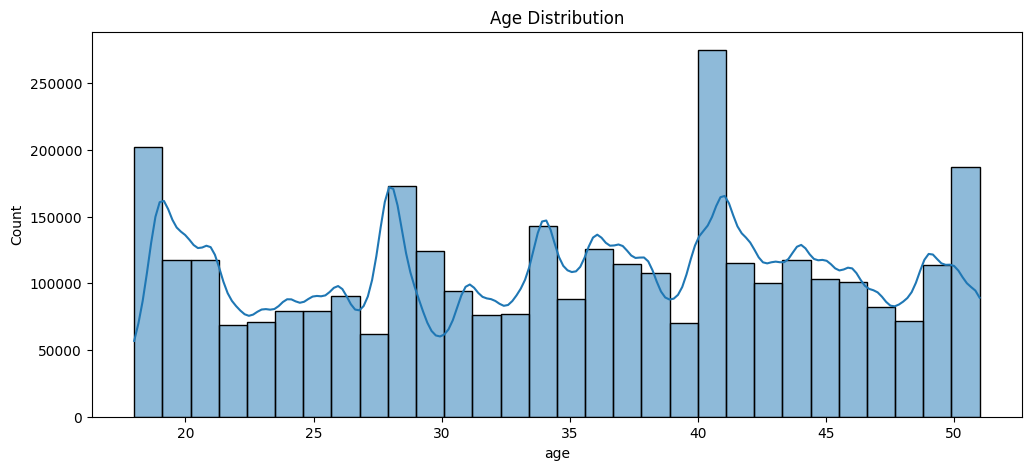

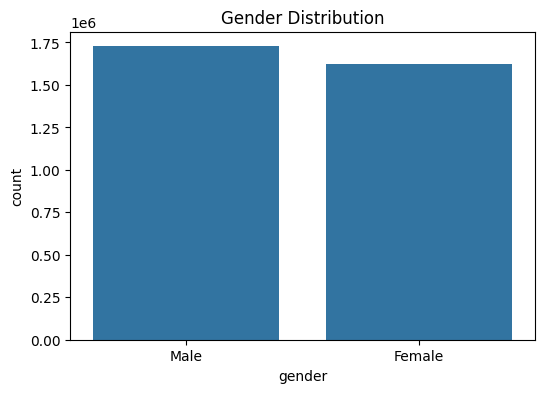

In [4]:
# Age distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

# Gender split
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=df)
plt.title("Gender Distribution")
plt.show()

### 4.2 Purchase Behavior

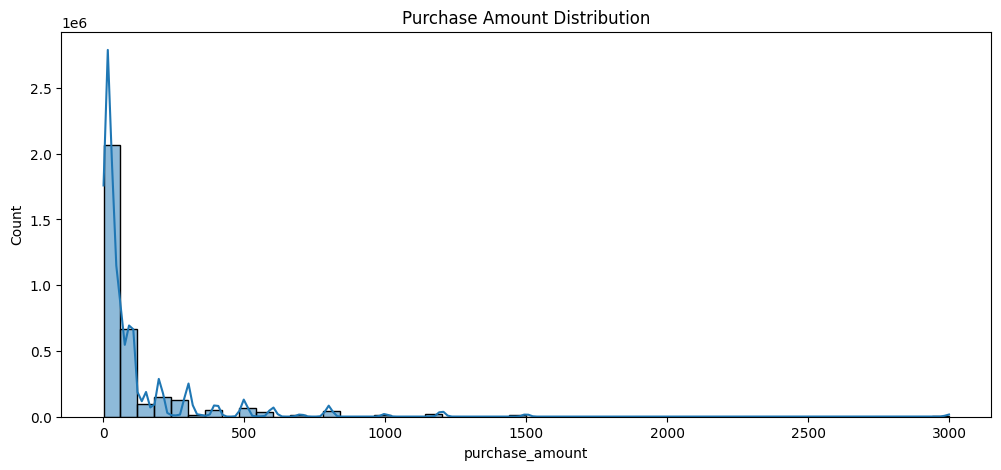

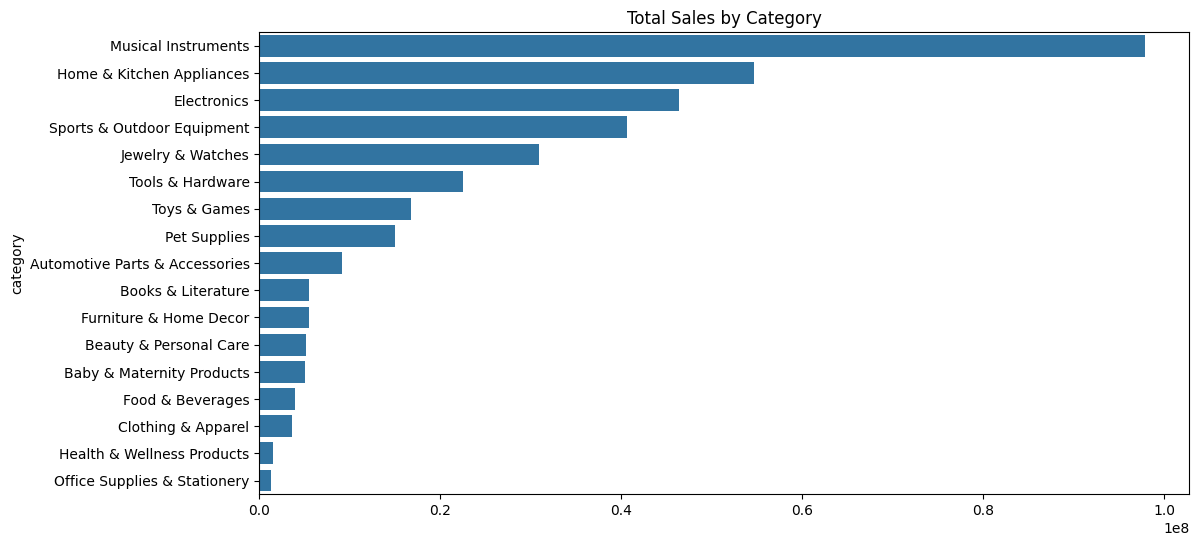

In [5]:
# Purchase amount distribution
plt.figure(figsize=(12, 5))
sns.histplot(df['purchase_amount'], bins=50, kde=True)
plt.title("Purchase Amount Distribution")
plt.show()

# Top categories
plt.figure(figsize=(12, 6))
category_sales = df.groupby('category')['purchase_amount'].sum().sort_values(ascending=False)
sns.barplot(x=category_sales.values, y=category_sales.index)
plt.title("Total Sales by Category")
plt.show()

## 5. Time Series Analysis

### 5.1 Purchase Trends

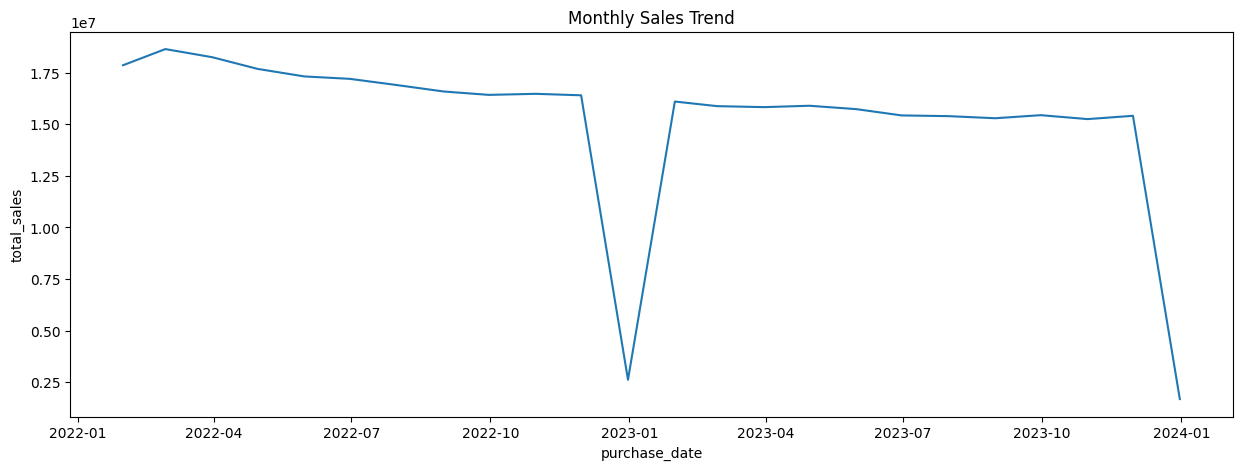

In [6]:
df['purchase_month'] = df['purchase_date'].dt.to_period('M')
monthly_sales = df.resample('M', on='purchase_date').agg(
    total_sales=('purchase_amount', 'sum'),
    transactions=('id', 'count')
).reset_index()

# Plot monthly trends
plt.figure(figsize=(15, 5))
sns.lineplot(data=monthly_sales, x='purchase_date', y='total_sales')
plt.title("Monthly Sales Trend")
plt.show()

## 6. Customer Segmentation

### 6.1 RFM Analysis

In [7]:
snapshot_date = df['purchase_date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('id').agg({
    'purchase_date': lambda x: (snapshot_date - x.max()).days,
    'id': 'count',
    'purchase_amount': 'sum'
}).rename(columns={
    'purchase_date': 'recency',
    'id': 'frequency',
    'purchase_amount': 'monetary'
})

# Create RFM segments
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+rfm.f_quartile.astype(str)+rfm.m_quartile.astype(str)

## 7. Return Analysis

### 7.1 Return Rates

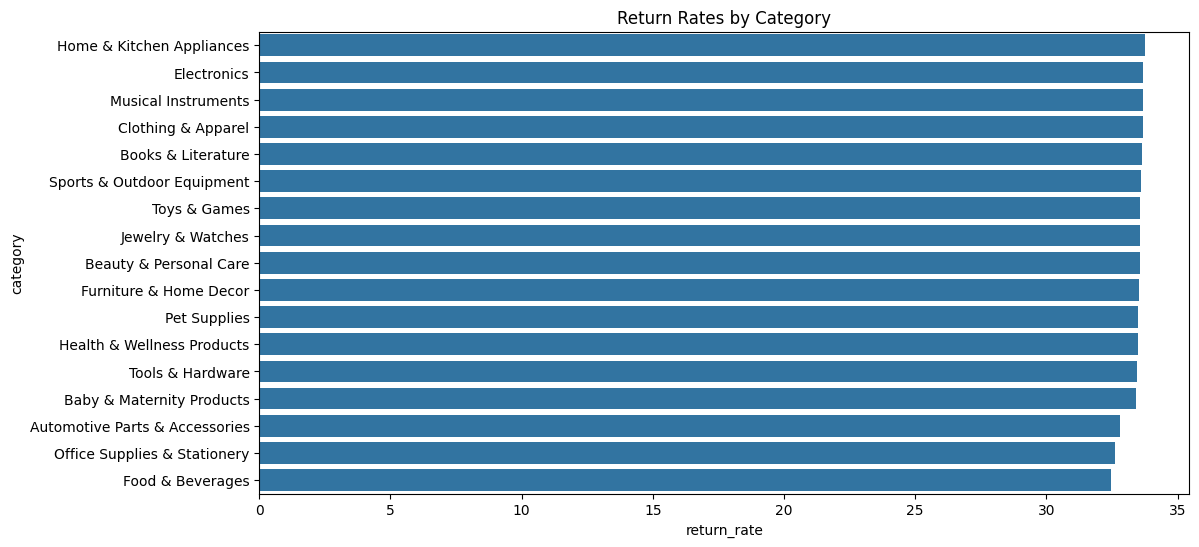

In [8]:
return_rates = df.groupby('category').agg(
    total_returns=('returned', lambda x: (x != 'no').sum()),
    total_purchases=('id', 'count')
).reset_index()

return_rates['return_rate'] = round(return_rates['total_returns'] / return_rates['total_purchases'] * 100, 2)

plt.figure(figsize=(12, 6))
sns.barplot(data=return_rates.sort_values('return_rate', ascending=False), 
            x='return_rate', y='category')
plt.title("Return Rates by Category")
plt.show()

## 8. Customer Lifetime Value (CLV)

In [9]:
clv = rfm.groupby('RFM_Score').agg(
    avg_value=('monetary', 'mean'),
    avg_frequency=('frequency', 'mean'),
    avg_lifespan=('recency', lambda x: (x.mean()/365))
).reset_index()

clv['CLV'] = clv['avg_value'] * clv['avg_frequency'] * clv['avg_lifespan']
clv.sort_values('CLV', ascending=False).head(10)

,RFM_Score,avg_value,avg_frequency,avg_lifespan,CLV
48,411,2429.810340,16.037415,0.700252,27287.318309
51,421,2184.827078,12.426357,0.772552,20974.348145
55,431,2142.850805,7.389404,1.252283,19829.144177
32,311,2349.084643,16.097405,0.350034,13236.255438
49,412,1142.591912,15.970588,0.703331,12834.282663
52,422,1126.266231,12.217096,0.773893,10648.533449
36,321,2248.899436,12.683654,0.362161,10330.364903
56,432,1089.263066,7.075953,1.306592,10070.652715
59,441,2174.206455,2.706967,1.407992,8286.743626
16,211,2344.052093,16.103038,0.191857,7241.913884
